In [4]:
##############################################################
### ITEM CLUSTERING                                        ###
### This notebook perform the items clustering of the data ###
##############################################################
###
### NOTE: Pycaret requires interaction before starting the modelling: click enter
###

In [5]:
###########################################
###            Packages                 ###
###########################################

import numpy as np
import pandas as pd
from statistics import mode
pd.set_option("display.max_rows", None, "display.max_columns", None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
from datetime import datetime
import re

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler,RobustScaler,StandardScaler

from pycaret.clustering import *
import sklearn.cluster as cluster
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from sklearn.cluster import cluster_optics_dbscan
from sklearn import metrics

In [6]:
###########################################
###            Functions                ###
###########################################

#### Variable eval, feature creation: ###

def plot_distr_num_var(feature,nb_bins): # feature within '', nb_bins = for the histogram
    print(data[feature].describe())
    plt.figure(figsize=[10,5])
    plt.title('Distribution of ' + feature)
    sns.boxplot(data=data, y=feature)
    plt.show()
    plt.figure(figsize=[10,5])
    data[feature].plot(kind='hist', bins = nb_bins)
    plt.figure(figsize=[10,5])
    plt.figure(figsize=[10,5])

def select_store(st_name): # in the format 'store_name'
    global data
    data = pd.DataFrame(df[df.store == st_name])

def feature_creation(df):
    global data
    # removing not-used features
    df = df.drop('id', axis = 1)
    df = df.drop('category', axis = 1)
    df = df.drop('department', axis = 1)
    df = df.drop('store', axis = 1)
    df = df.drop('region', axis = 1)
    df = df.drop('store_code', axis = 1)
    #creating frequency of sales column:
    df['frequency'] = df.iloc[:,1:].sum(axis = 1)

    #creating recency column
    d1 = df.columns.get_loc('d_1')
    d1913 = df.columns.get_loc('d_1913')

    recency = []
    for i in range(len(df)):
        for j in reversed(range(d1,d1913+1)):
            if df.iloc[i, j] ==0:
                continue
            else:
                recency.append(d1913-j+1)
                break

    df['recency'] = recency

    # delete single days counts
    drop_c = len(df.T)-2
    df.drop(df.iloc[:, 1:drop_c], inplace = True, axis = 1)

    print(df.head())

    # evaluate correlation between the 2 created features
    print(df[['frequency', 'recency']].corr())

    # return dataframe
    data = pd.DataFrame(df)

### Feature log tranform ###
    
def log_tranform_feat(df):
    global data
    df['frequency_ln'] = df['frequency'].apply(lambda x: np.log1p(x))
    df['recency_ln'] = df['recency'].apply(lambda x: np.log1p(x))

    data = pd.DataFrame(df)

### Train-test split ###

def train_test_split(df, fraction_train, rn_state): #fraction in the format 0.95
    global data_train
    global data_unseen

    df_train = df.sample(frac=fraction_train, random_state=rn_state)
    df_unseen = df.drop(df_train.index)

    df_train.reset_index(drop=True, inplace=True)
    df_unseen.reset_index(drop=True, inplace=True)

    print('Data for Modeling: ' + str(df_train.shape))
    print('Unseen Data For Predictions: ' + str(df_unseen.shape))

    data_train = pd.DataFrame(df_train)
    data_unseen = pd.DataFrame(df_unseen)

### Modelling and evaluation ###

def cluster_model(fit_method,n_clusters):
    global model
    global model_results
    exp_clu101 = setup(data_train, normalize = True,
                   ignore_features = ['item','frequency','recency'],
                   normalize_method = 'minmax',
                   session_id = 17)

    m = create_model('kmeans', num_clusters = n_clusters)
    m_results = assign_model(m)

    model = m
    model_results = pd.DataFrame(m_results)

def plot_cluster(m_results,st_name):
    title = ('Cluster distribution on the original variables - '+ st_name)
    fig = px.scatter(x =  m_results['recency'], y =  m_results['frequency'], color = m_results['Cluster'], title = title )
    fig.update_traces(marker=dict(size=12, line=dict(width=2, color='DarkSlateGrey')), selector=dict(mode='markers'))
    fig.update_layout(
        autosize=False,
        width=800,
        height=800,)
    fig.update_layout(
        xaxis_title="Days since last purchase",
        yaxis_title="Total number of sold items",
        )
    fig.show()

def plot_cluster_distr(m_results, st_name, perc):
    plt.figure(figsize=[20,10])
    
    order= m_results['Cluster'].value_counts().index
    ax = sns.countplot(m_results['Cluster'], order = order)
    if perc == True:
        title = ('Percentage of items per cluster - ' + st_name)
        total = len(m_results)
        for p in ax.patches:
                    percentage = f'{100 * p.get_height() / total:.1f}%\n'
                    x = p.get_x() + p.get_width() / 2
                    y = p.get_height()
                    ax.annotate(percentage, (x, y), rotation=45, annotation_clip=False)
    else:
        title = ('Number of items per cluster - ' + st_name)
        for p in ax.patches:
                    nb_items = f'{p.get_height()}\n'
                    x = p.get_x() + p.get_width() / 2
                    y = p.get_height()
                    ax.annotate(nb_items, (x, y), rotation=45, annotation_clip=False)
    plt.title(title,  fontsize=20)
    plt.xlabel('')
    plt.tight_layout()
    plt.show()

def predictions(model_, mod_res, dt_unseen):
    global unseen_predictions
    uns_pred = predict_model(model_, data=dt_unseen)

    train_sorted = mod_res.sort_values(["Cluster"], ascending=True)
    unseen_sorted = uns_pred.sort_values(["Cluster"], ascending=True)

    fig = px.scatter(x =  train_sorted['recency'], y =  train_sorted['frequency'], color = train_sorted['Cluster'], opacity=0.2, title = 'Predictions on unseen data' )
    fig.update_traces(marker=dict(size=12, line=dict(width=1, color='DarkSlateGrey')), selector=dict(mode='markers'))
    fig.update_layout(
        autosize=False,
        width=1000,
        height=1000)

    fig2 = px.scatter(x=unseen_sorted["recency"], y=unseen_sorted["frequency"], color = unseen_sorted['Cluster'],
        symbol = unseen_sorted['Cluster'],symbol_sequence=['diamond', 'diamond', 'diamond', 'diamond', 'diamond'])
    fig2.update_traces(marker=dict(size=12, line=dict(width=2,
                                            color='Red')))

    fig.add_trace(fig2.data[0])
    fig.add_trace(fig2.data[1])
    fig.add_trace(fig2.data[2])
    fig.add_trace(fig2.data[3])
    fig.add_trace(fig2.data[4])

    fig.update_layout(
    xaxis_title="Days since last purchase",
    yaxis_title="Total number of sold items",legend_title="Clusters train and test data"
    )

    fig.show()

    unseen_predictions = pd.DataFrame(uns_pred)

def cluster_rename(m_results):
    cluster_dict = {'Cluster 2': "Hot Items", 'Cluster 1': 'Common Items','Cluster 4':'New Items','Cluster 0': 'Emerging/Fading Items','Cluster 3':'Bad/Old Items'}
    m_results['Cluster_name'] = m_results['Cluster']
    m_results['Cluster_name'].replace(cluster_dict, inplace=True)

################################################

In [7]:
#import data
df= pd.read_csv("item_sales.csv")
#pd_sales = pd.read_csv('sales_mean_prices_df.csv', index_col= 0)

In [8]:
# Nans: NO Nans, see below
df.isnull().any()

id            False
item          False
category      False
department    False
store         False
store_code    False
region        False
d_1           False
d_2           False
d_3           False
d_4           False
d_5           False
d_6           False
d_7           False
d_8           False
d_9           False
d_10          False
d_11          False
d_12          False
d_13          False
d_14          False
d_15          False
d_16          False
d_17          False
d_18          False
d_19          False
d_20          False
d_21          False
d_22          False
d_23          False
d_24          False
d_25          False
d_26          False
d_27          False
d_28          False
d_29          False
d_30          False
d_31          False
d_32          False
d_33          False
d_34          False
d_35          False
d_36          False
d_37          False
d_38          False
d_39          False
d_40          False
d_41          False
d_42          False
d_43          False


In [9]:
################################
###   1) Store selection     ###
################################

# The model is being created based on data from the most selling store: Tribeca

df.store.value_counts()

Greenwich_Village    3049
Harlem               3049
Tribeca              3049
Brooklyn             3049
South_End            3049
Roxbury              3049
Back_Bay             3049
Midtown_Village      3049
Yorktown             3049
Queen_Village        3049
Name: store, dtype: int64

In [10]:
################################
###          Tribeca         ###
################################

# Define store name:

store_name = 'Tribeca'

In [11]:
#select the store to analyse
# data are stored in the dataframe 'data' 
select_store(store_name)

In [12]:
data.head()

id              item    category    department  \
6098  ACCESORIES_1_001_NYC_3  ACCESORIES_1_001  ACCESORIES  ACCESORIES_1   
6099  ACCESORIES_1_002_NYC_3  ACCESORIES_1_002  ACCESORIES  ACCESORIES_1   
6100  ACCESORIES_1_003_NYC_3  ACCESORIES_1_003  ACCESORIES  ACCESORIES_1   
6101  ACCESORIES_1_004_NYC_3  ACCESORIES_1_004  ACCESORIES  ACCESORIES_1   
6102  ACCESORIES_1_005_NYC_3  ACCESORIES_1_005  ACCESORIES  ACCESORIES_1   

        store store_code    region  d_1  d_2  d_3  d_4  d_5  d_6  d_7  d_8  \
6098  Tribeca      NYC_3  New York    0    0    0    0    0    0    0    0   
6099  Tribeca      NYC_3  New York    0    0    0    0    0    0    0    0   
6100  Tribeca      NYC_3  New York    0    0    0    0    0    0    0    0   
6101  Tribeca      NYC_3  New York    0    0    0    0    0    0    0    0   
6102  Tribeca      NYC_3  New York    0    0    0    0    0    0    0    0   

      d_9  d_10  d_11  d_12  d_13  d_14  d_15  d_16  d_17  d_18  d_19  d_20  \
6098    0     0     0     0     0     0     0     0     0     0     0     0   
6099    0     0     0     0     0     0     0     0     0     0     0     0   
6100    0     0     0     0     0     0     0     0     0     0     0     0   
6101    0     0     0     0    10     2     0     0     0     0     0     0   
6102    0     0     0     0     0     0     0     0     0     0     0     0   

      d_21  d_22  d_23  d_24  d_25  d_26  d_27  d_28  d_29  d_30  d_31  d_32  \
6098     0     0     0     0     0     0     0     0     0     0     0     0   
6099     0     0     0     0     0     0     0     0     0     0     0     0   
6100     0     0     0     0     0     0     0     0     0     0     0     0   
6101     0     0     0     0     0     0     0     0     0     0     0     0   
6102     0     0     0     0     0     0     0     0     0     0     0     0   

      d_33  d_34  d_35  d_36  d_37  d_38  d_39  d_40  d_41  d_42  d_43  d_44  \
6098     0     0     0     0     0     0     0     0     0     0     0     0   
6099     0     0     0     0     0     0     0     0     0     0     0     0   
6100     0     0     0     0     0     0     0     0     0     0     0     0   
6101     0     0     3     4     0     0     0    12     0     0     0     0   
6102     0     0     0     0     0     0     0     0     0     0     0     0   

      d_45  d_46  d_47  d_48  d_49  d_50  d_51  d_52  d_53  d_54  d_55  d_56  \
6098     0     0     0     0     0     0     0     0     0     0     0     0   
6099     1     0     0     0     0     0     0     0     0     0     0     0   
6100     0     0     0     0     0     0     0     0     0     0     0     0   
6101     0     0     0     0     0     0     0     0     0     0     0     0   
6102     0     0     0     0     0     0     0     0     0     0     0     0   

      d_57  d_58  d_59  d_60  d_61  d_62  d_63  d_64  d_65  d_66  d_67  d_68  \
6098     0     0     0     0     0     0     0     0     0     0     0     0   
6099     0     0     0     0     0     0     0     0     0     0     0     0   
6100     0     0     0     0     0     0     0     0     0     0     0     0   
6101     0     0     0     0     0     0     0     0     0     0     0     0   
6102     0     0     0     0     0     0     0     0     0     0     0     0   

      d_69  d_70  d_71  d_72  d_73  d_74  d_75  d_76  d_77  d_78  d_79  d_80  \
6098     0     0     0     0     0     0     0     0     0     0     0     0   
6099     0     0     0     0     0     0     0     0     0     0     0     0   
6100     0     0     0     0     0     0     0     0     0     0     0     0   
6101     0     0     0     0     0     0     0     0     0     0     0     0   
6102     0     0     0     0     0     0     0     0     0     0     0     0   

      d_81  d_82  d_83  d_84  d_85  d_86  d_87  d_88  d_89  d_90  d_91  d_92  \
6098     0     0     0     0     0     0     0     0     0     0     0     0   
6099     0     0     0     0     0     0     0     0     0  

In [13]:
##########################################
###     2) Feature preparation         ###
##########################################

In [14]:
feature_creation(data)

                  item  frequency  recency
6098  ACCESORIES_1_001        758        1
6099  ACCESORIES_1_002        452        2
6100  ACCESORIES_1_003        137        1
6101  ACCESORIES_1_004      10442        1
6102  ACCESORIES_1_005       2663        1
           frequency  recency
frequency    1.00000 -0.03487
recency     -0.03487  1.00000


In [15]:
# no correlation between the 2 created features

count     3049.00000
mean      3669.45884
std       8480.23042
min         10.00000
25%        597.00000
50%       1475.00000
75%       3472.00000
max     250502.00000
Name: frequency, dtype: float64


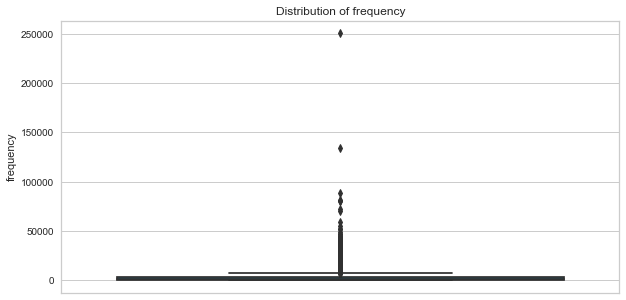

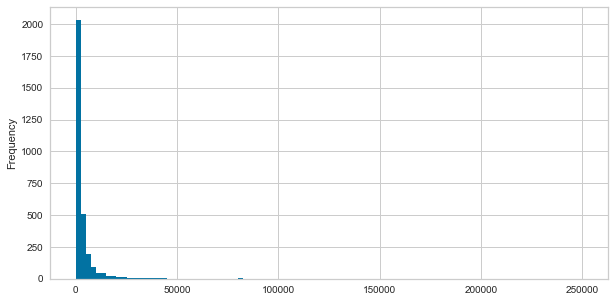

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

In [16]:
# Analyze variable distributions
plot_distr_num_var('frequency',100)

count   3049.00000
mean       6.03837
std       28.16181
min        1.00000
25%        1.00000
50%        1.00000
75%        3.00000
max      917.00000
Name: recency, dtype: float64


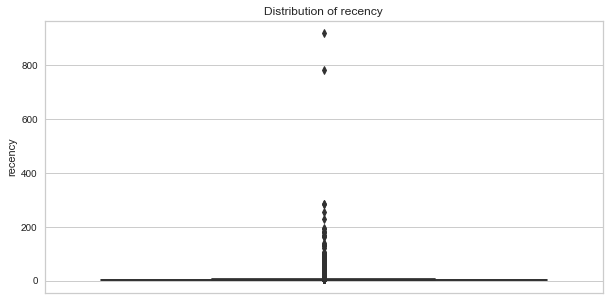

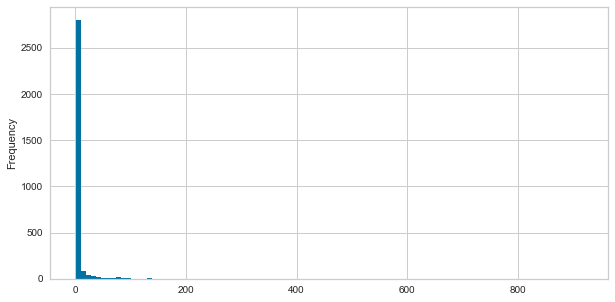

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

In [17]:
plot_distr_num_var('recency',100)

In [18]:
# Very skewed variables, need to be log transformed

In [19]:
log_tranform_feat(data)

count   3049.00000
mean       7.30714
std        1.30715
min        2.39790
25%        6.39359
50%        7.29709
75%        8.15277
max       12.43123
Name: frequency_ln, dtype: float64


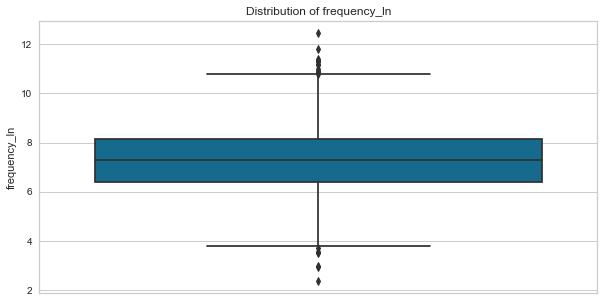

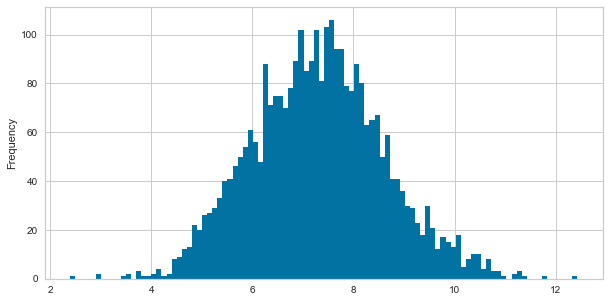

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

In [20]:
# Analyze variable distributions after log tranform
plot_distr_num_var('frequency_ln',100)

count   3049.00000
mean       1.17119
std        0.85203
min        0.69315
25%        0.69315
50%        0.69315
75%        1.38629
max        6.82220
Name: recency_ln, dtype: float64


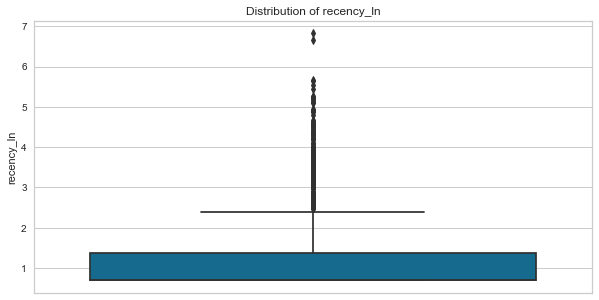

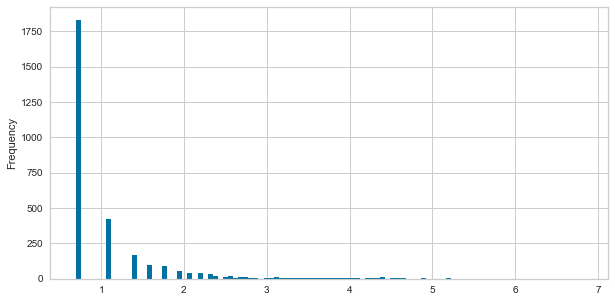

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

In [21]:
plot_distr_num_var('recency_ln',100)

In [22]:
# Recency remain skewed: most products are sold recently, could see an effect on the performace of the k-means model<br>
# Not remove outliers (since I´m interested in how all products behave), need to evaluate if the algorithm used could preform badly because of the variable distributions

In [23]:
##########################################
###       3) Train-test split          ###
##########################################

In [24]:
train_test_split(data, fraction_train = 0.95, rn_state = 17)
data_train.head()

Data for Modeling: (2897, 5)
Unseen Data For Predictions: (152, 5)


,item,frequency,recency,frequency_ln,recency_ln
0,SUPERMARKET_3_703,57,1,4.06044,0.69315
1,ACCESORIES_2_015,127,22,4.85203,3.13549
2,SUPERMARKET_2_086,4767,1,8.46968,0.69315
3,HOME_&_GARDEN_1_348,5752,1,8.65748,0.69315
4,ACCESORIES_1_165,712,1,6.56948,0.69315


In [25]:
############################################
###       3) Data normalization          ###
############################################

# Data normalization is done directly inside the model with Pycaret

In [26]:
#######################################
###       4) Cluster model          ###
#######################################

In [27]:
cluster_model('kmeans',5)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.40940,2831.16380,0.81550,0,0,0


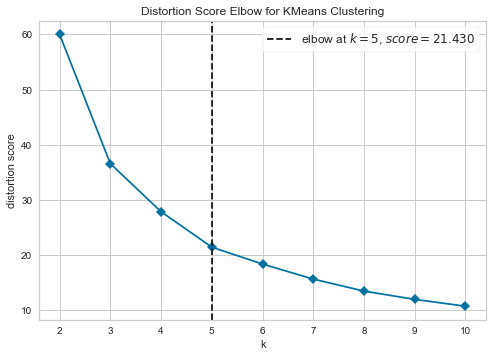

In [28]:
# finding the best number of cluster and then it was applied in the model: 5
plot_model(model, plot = 'elbow')

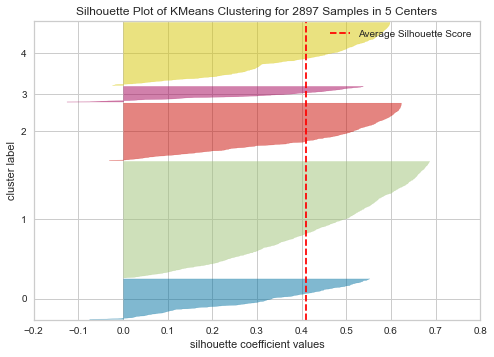

In [29]:
# Evaluation of the model with silhouette plot:

plot_model(model, plot = 'silhouette')

In [30]:
# Cluster plot based on the used log tranformed variables

plot_model(model)

In [31]:
# plot clusters on the original variables frequency and recency
plot_cluster(model_results, store_name)

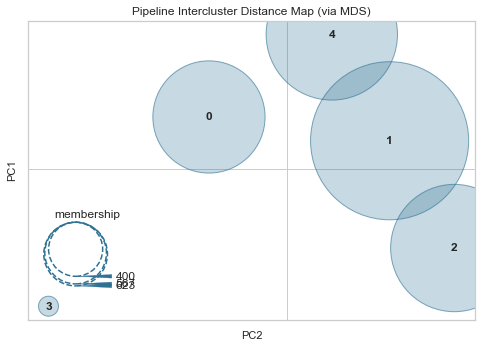

In [32]:
# distance plot to evaluate the distances between clusters
# cluster 0 and 3 are clearly separated in the data
plot_model(model, plot = 'distance')

In [33]:
# plot distributions of items within the different clusters
plot_model(model, plot = 'distribution')

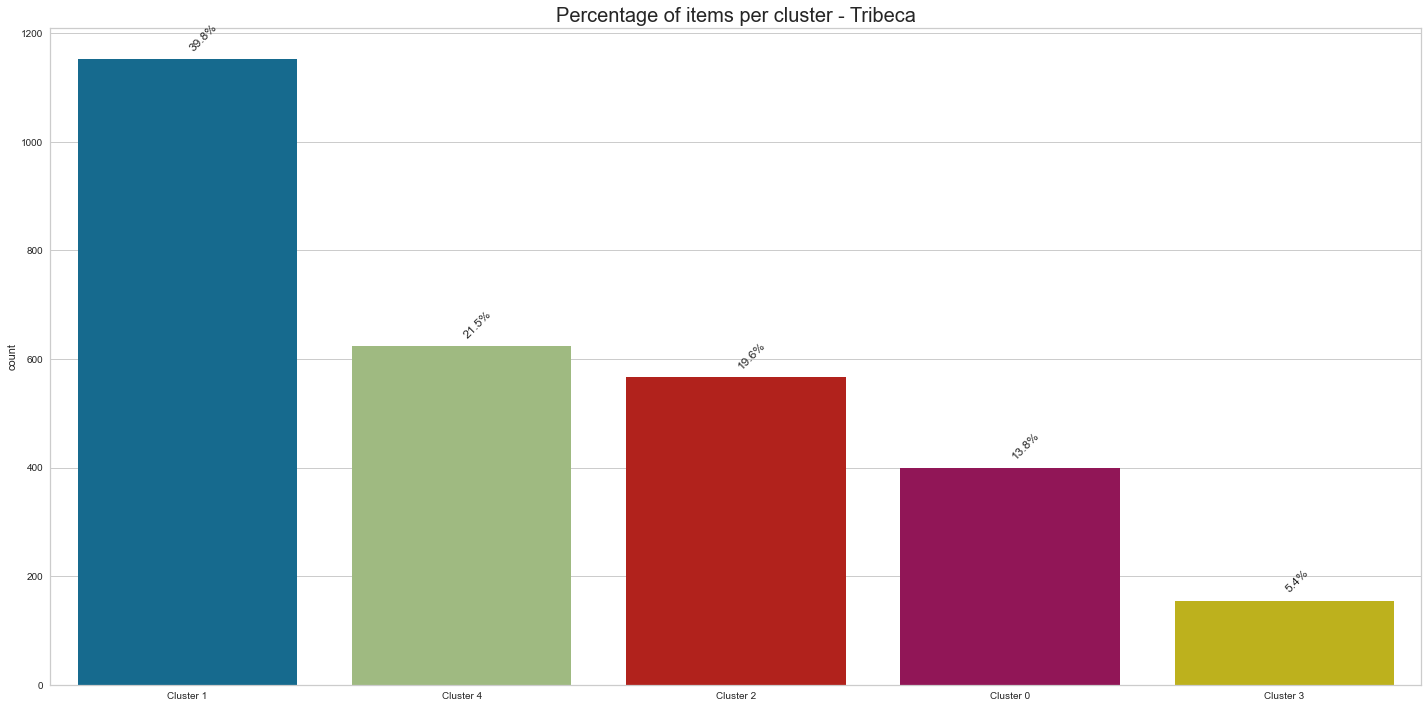

In [34]:
plot_cluster_distr(model_results,store_name,True)

In [35]:
# plot distribution of feature 1 frequency within the clusters
plot_model(model, plot = 'distribution', feature = 'frequency')

In [36]:
# plot the distribution of feature 2 recency within the clusters:
plot_model(model, plot = 'distribution', feature = 'recency')

In [37]:
#######################################
###        5) Predictions           ###
#######################################

In [38]:
# Calculate and evaluate the prediction of the model on unseen data

predictions(model, model_results, data_unseen)

In [39]:
#########################################
###        6) Saving model          ###
#########################################

model_name = ('cluster_model_items')
save_model(model, model_name);

Transformation Pipeline and Model Successfully Saved


In [40]:
##################################################
###        7) Cluster interpretation           ###
##################################################

In [41]:
#### Cluster interpretation ###


### Cluster 2 - Hot Items:
### Cluster with high frequency and low recency: these are the hot/top selling products: 567 items
### Inside this cluster could appear as well some seasonal products with high selling. To identify those a more in depth evaluation is needed

### Cluster 1 - Common Items:
### Cluster with medium frequency and low recency: these are common products, should be most of the product and as a matter of fact it is the cluster with more items: 1152 items
### Inside this cluster could appear as well some seasonal products with medium selling. To identify those a more in depth evaluation is needed

### Cluster 4 - New Items:
### Cluster with low frequency and low recency: there are new/appearing products: 623 items.
### Inside this cluster could appear as well some low selling seasonal products. To identify those a more in depth evaluation is needed

### Cluster 0 - Transition Items:
### Cluster with medium recency and a wide range in frequency: they could be emerging products (lower-left part of the cluster) or fading products (upper-right) part of the cluster
### Inside this cluster could appear as well some seasonal products. To identify those a more in depth evaluation is needed

### Cluster 3 - Old or Bad Items:
### Cluster withhigh recency and a wide range in frequency: they could be bad products, that never sold (lower part of the cluster) or old product (left part of the cluster)
### that sold in the past but now are not selling anymore
### Inside this cluster could appear as well some seasonal products. To identify those a more in depth evaluation is needed


In [42]:
###############################################
### Append test data to results to be saved ###
###############################################

model_results = model_results.append(unseen_predictions, ignore_index=True)


In [43]:
#############################
###   Cluster re-naming:  ###
#############################

cluster_rename(model_results)

In [44]:
##############################################################################
### Evaluating the model for the 10 most and less sold product in New York ###
### The 10 most sold product in New York are:                              ###
##############################################################################

most_sold_NY = ['SUPERMARKET_3_090', 'SUPERMARKET_3_586','SUPERMARKET_3_252','SUPERMARKET_3_120',
    'SUPERMARKET_3_587','SUPERMARKET_3_808','SUPERMARKET_3_635','SUPERMARKET_3_541','SUPERMARKET_3_714','SUPERMARKET_3_555']
less_sold_NY = ['HOME_&_GARDEN_1_300','ACCESORIES_2_027','SUPERMARKET_2_209',
    'SUPERMARKET_2_117','ACCESORIES_2_084','HOME_&_GARDEN_2_397', 'ACCESORIES_2_111','HOME_&_GARDEN_2_175','ACCESORIES_2_119','HOME_&_GARDEN_2_060']

for i in most_sold_NY:
    _ = model_results[['item','Cluster_name']][model_results.item == i]
    print(_)

for i in less_sold_NY:
    _ = model_results[['item','Cluster_name']][model_results.item == i]
    print(_)

                   item Cluster_name
2643  SUPERMARKET_3_090    Hot Items
                  item Cluster_name
110  SUPERMARKET_3_586    Hot Items
                   item Cluster_name
1722  SUPERMARKET_3_252    Hot Items
                  item Cluster_name
223  SUPERMARKET_3_120    Hot Items
                   item Cluster_name
1829  SUPERMARKET_3_587    Hot Items
                   item Cluster_name
2233  SUPERMARKET_3_808    Hot Items
                   item Cluster_name
2855  SUPERMARKET_3_635    Hot Items
                  item Cluster_name
240  SUPERMARKET_3_541    Hot Items
                   item Cluster_name
1548  SUPERMARKET_3_714    Hot Items
                   item Cluster_name
2829  SUPERMARKET_3_555    Hot Items
                    item           Cluster_name
551  HOME_&_GARDEN_1_300  Emerging/Fading Items
                 item Cluster_name
824  ACCESORIES_2_027    New Items
                  item Cluster_name
232  SUPERMARKET_2_209    New Items
                  item      

In [45]:
# All most sold product are in Cluster 2 (as expected)
# Less sold products are in Cluster 0, 3 and 4. It is expected since products that sold very little can be either bad/old products, new products or
# transition products (emerging or fading products)

In [46]:
#########################################
###        8) Saving results          ###
#########################################

In [47]:
model_results.head()

,item,frequency,recency,frequency_ln,recency_ln,Cluster,Cluster_name
0,SUPERMARKET_3_703,57,1,4.06044,0.69315,Cluster 4,New Items
1,ACCESORIES_2_015,127,22,4.85203,3.13549,Cluster 0,Emerging/Fading Items
2,SUPERMARKET_2_086,4767,1,8.46968,0.69315,Cluster 2,Hot Items
3,HOME_&_GARDEN_1_348,5752,1,8.65748,0.69315,Cluster 2,Hot Items
4,ACCESORIES_1_165,712,1,6.56948,0.69315,Cluster 4,New Items


In [48]:
# save results
filename = ('cluster_model_results_' + store_name + '.csv')
model_results.to_csv(filename)

In [49]:
#############################################################
###          Applying the model to Other Stores           ###
#############################################################

In [50]:
df.store.value_counts()

Greenwich_Village    3049
Harlem               3049
Tribeca              3049
Brooklyn             3049
South_End            3049
Roxbury              3049
Back_Bay             3049
Midtown_Village      3049
Yorktown             3049
Queen_Village        3049
Name: store, dtype: int64

In [51]:
#########################################
###        Greenwich_Village          ###
#########################################

               item  frequency  recency
0  ACCESORIES_1_001        600        1
1  ACCESORIES_1_002        493        5
2  ACCESORIES_1_003        288        1
3  ACCESORIES_1_004       3288        1
4  ACCESORIES_1_005       1849        1
           frequency  recency
frequency    1.00000 -0.03892
recency     -0.03892  1.00000


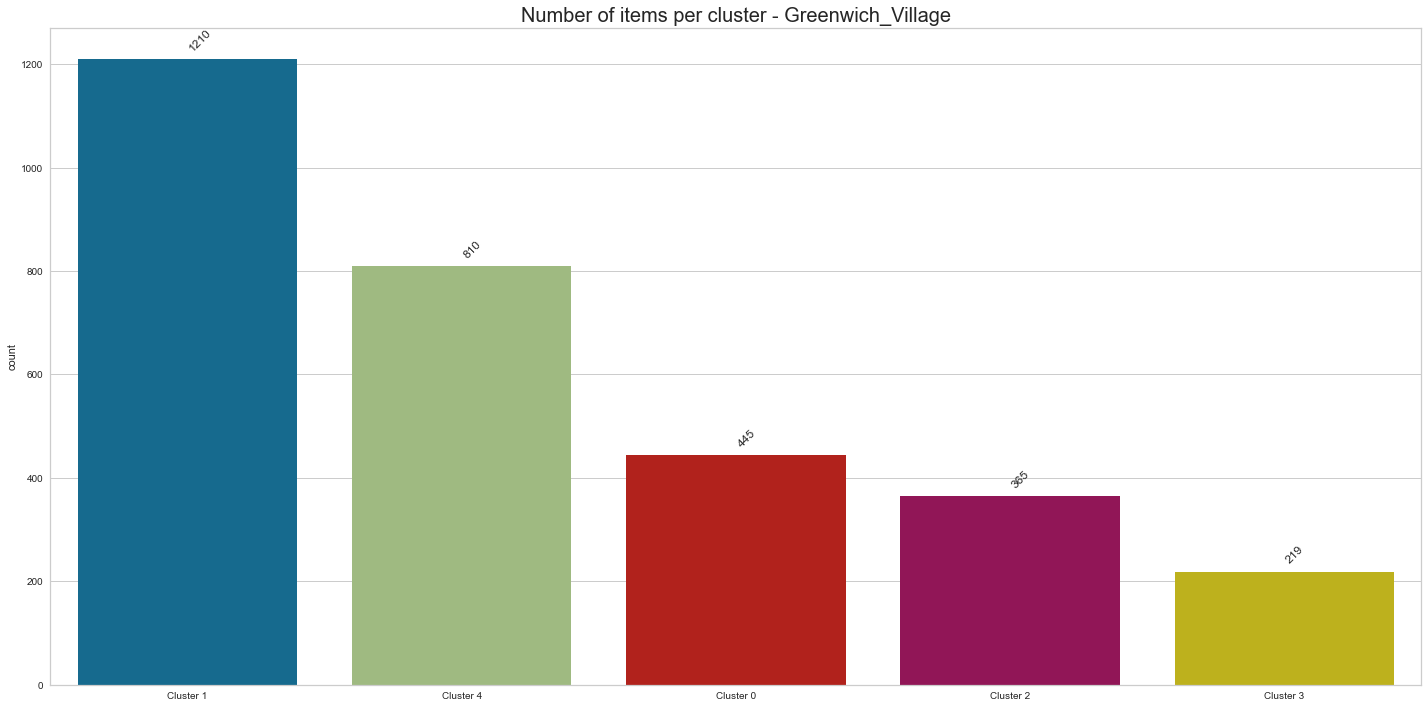

In [52]:
# store selection
store_name = 'Greenwich_Village'
select_store(store_name)

# prepare the data
feature_creation(data)
log_tranform_feat(data)

# apply the model and plot results
model_results = predict_model(model, data=data)
plot_cluster(model_results, store_name)
plot_cluster_distr(model_results,store_name,False)

# cluster renaming
cluster_rename(model_results)
model_results.head()

# saving results
filename = ('cluster_model_results_' + store_name + '.csv')
model_results.to_csv(filename)

In [53]:
################################
###        Harlem            ###
################################

                  item  frequency  recency
3049  ACCESORIES_1_001        542        1
3050  ACCESORIES_1_002        328        3
3051  ACCESORIES_1_003        145        2
3052  ACCESORIES_1_004       7503        1
3053  ACCESORIES_1_005       2039        1
           frequency  recency
frequency    1.00000 -0.04644
recency     -0.04644  1.00000


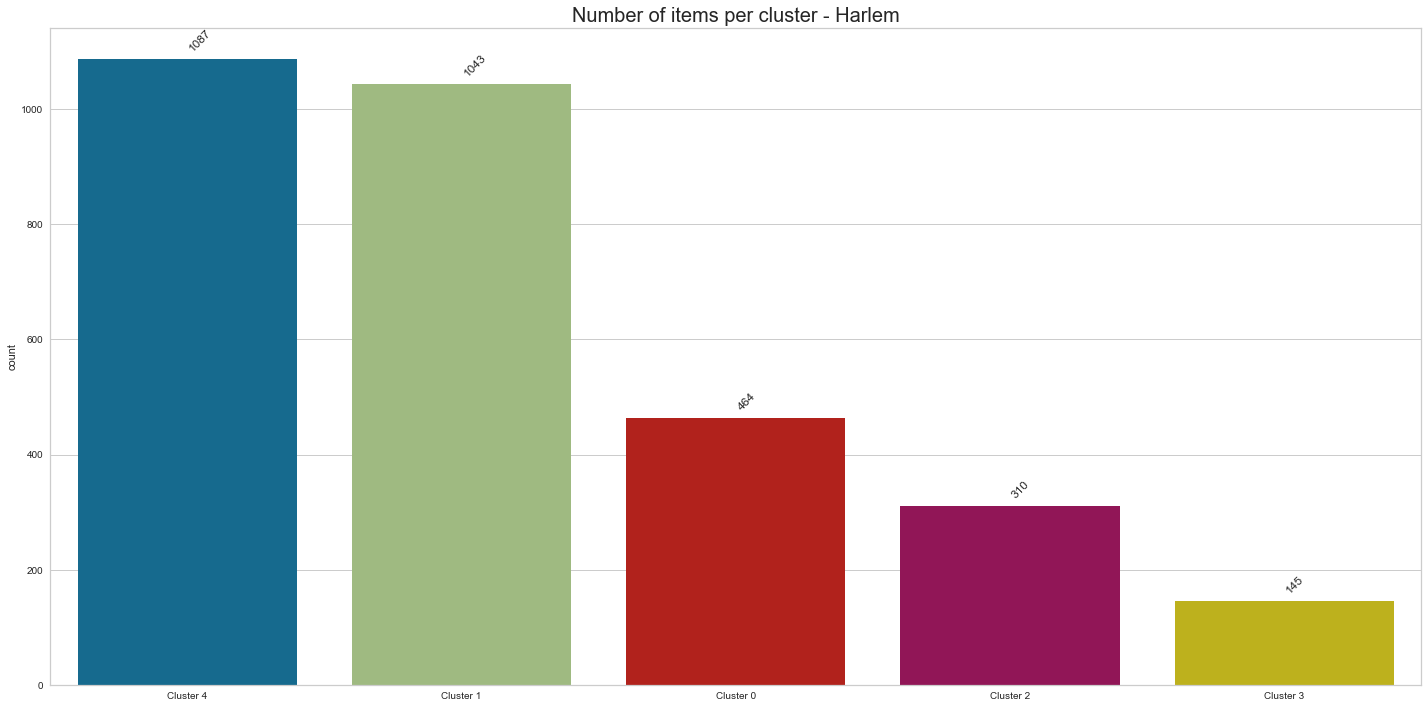

In [54]:
# store selection
store_name = 'Harlem'
select_store(store_name)

# prepare the data
feature_creation(data)
log_tranform_feat(data)

# apply the model and plot results
model_results = predict_model(model, data=data)
plot_cluster(model_results, store_name)
plot_cluster_distr(model_results,store_name,False)

# cluster renaming
cluster_rename(model_results)

# saving results
filename = ('cluster_model_results_' + store_name + '.csv')
model_results.to_csv(filename)

In [55]:
################################
###        Brooklyn          ###
################################

                  item  frequency  recency
9147  ACCESORIES_1_001        635        1
9148  ACCESORIES_1_002        323        1
9149  ACCESORIES_1_003        161        3
9150  ACCESORIES_1_004       1588        2
9151  ACCESORIES_1_005        930        1
           frequency  recency
frequency    1.00000 -0.06039
recency     -0.06039  1.00000


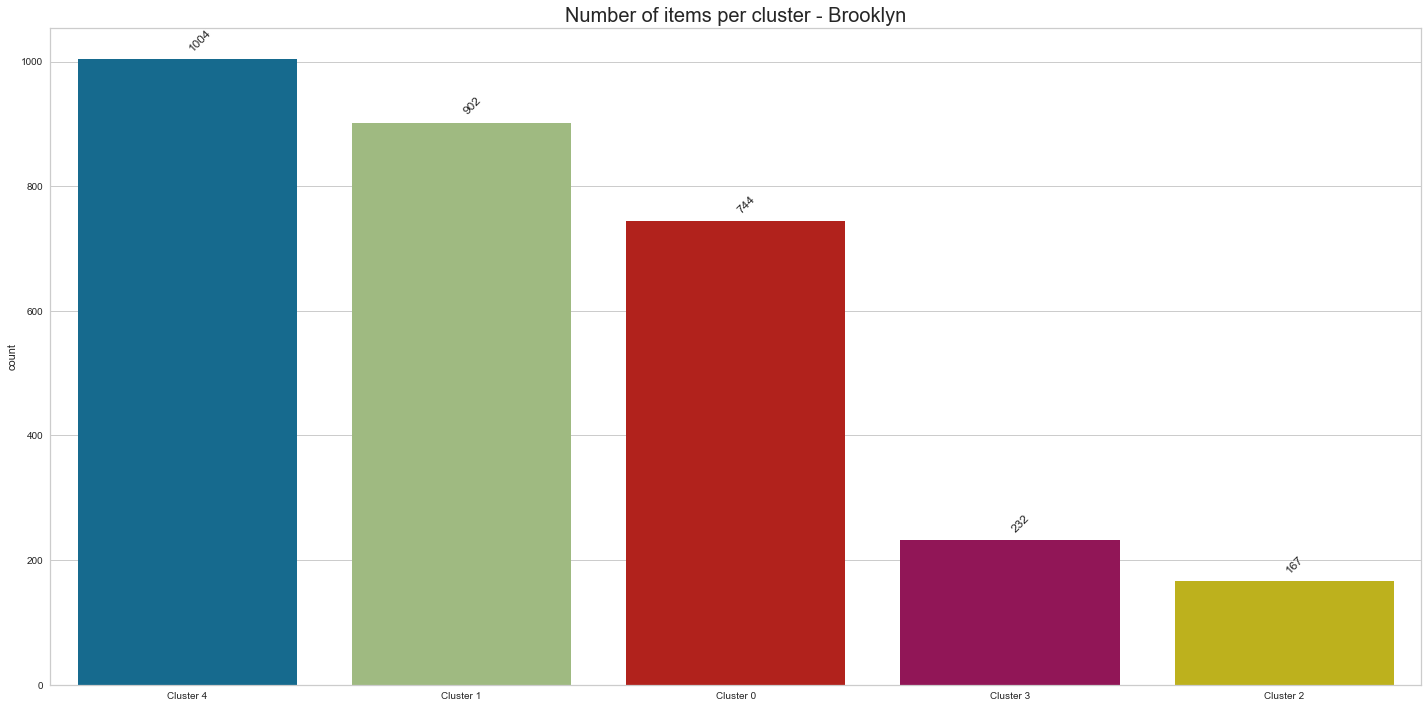

In [56]:
# store selection
store_name = 'Brooklyn'
select_store(store_name)

# prepare the data
feature_creation(data)
log_tranform_feat(data)

# apply the model and plot results
model_results = predict_model(model, data=data)
plot_cluster(model_results, store_name)
plot_cluster_distr(model_results,store_name,False)

# cluster renaming
cluster_rename(model_results)

# saving results
filename = ('cluster_model_results_' + store_name + '.csv')
model_results.to_csv(filename)

In [57]:
################################
###        South_End         ###
################################

                   item  frequency  recency
12196  ACCESORIES_1_001        260        1
12197  ACCESORIES_1_002        220        1
12198  ACCESORIES_1_003         99       12
12199  ACCESORIES_1_004       2951        1
12200  ACCESORIES_1_005       1124        1
           frequency  recency
frequency    1.00000 -0.04555
recency     -0.04555  1.00000


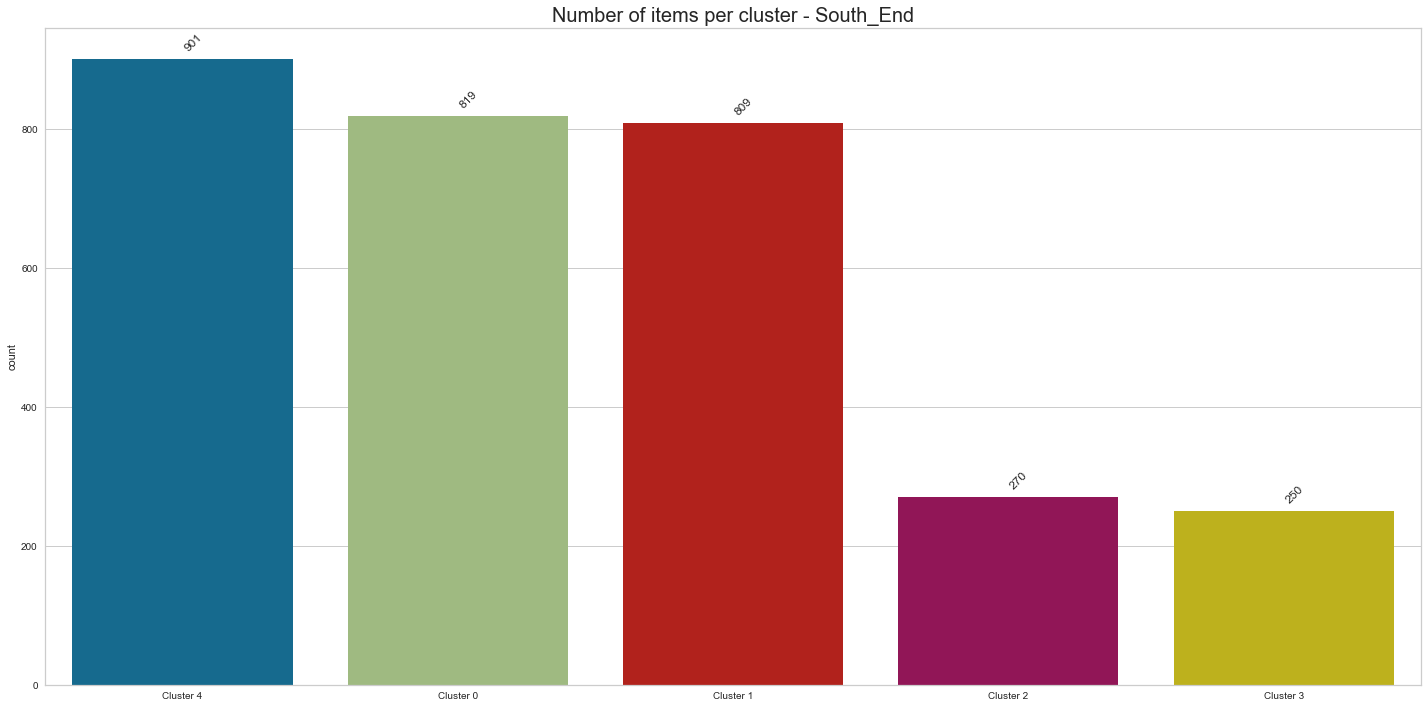

In [58]:
# store selection
store_name = 'South_End'
select_store(store_name)

# prepare the data
feature_creation(data)
log_tranform_feat(data)

# apply the model and plot results
model_results = predict_model(model, data=data)
plot_cluster(model_results, store_name)
plot_cluster_distr(model_results,store_name,False)

# cluster renaming
cluster_rename(model_results)

# saving results
filename = ('cluster_model_results_' + store_name + '.csv')
model_results.to_csv(filename)

In [59]:
################################
###        Roxbury           ###
################################

                   item  frequency  recency
15245  ACCESORIES_1_001        402        5
15246  ACCESORIES_1_002        300        1
15247  ACCESORIES_1_003        101        8
15248  ACCESORIES_1_004       3570        1
15249  ACCESORIES_1_005       2016        2
           frequency  recency
frequency    1.00000 -0.03166
recency     -0.03166  1.00000


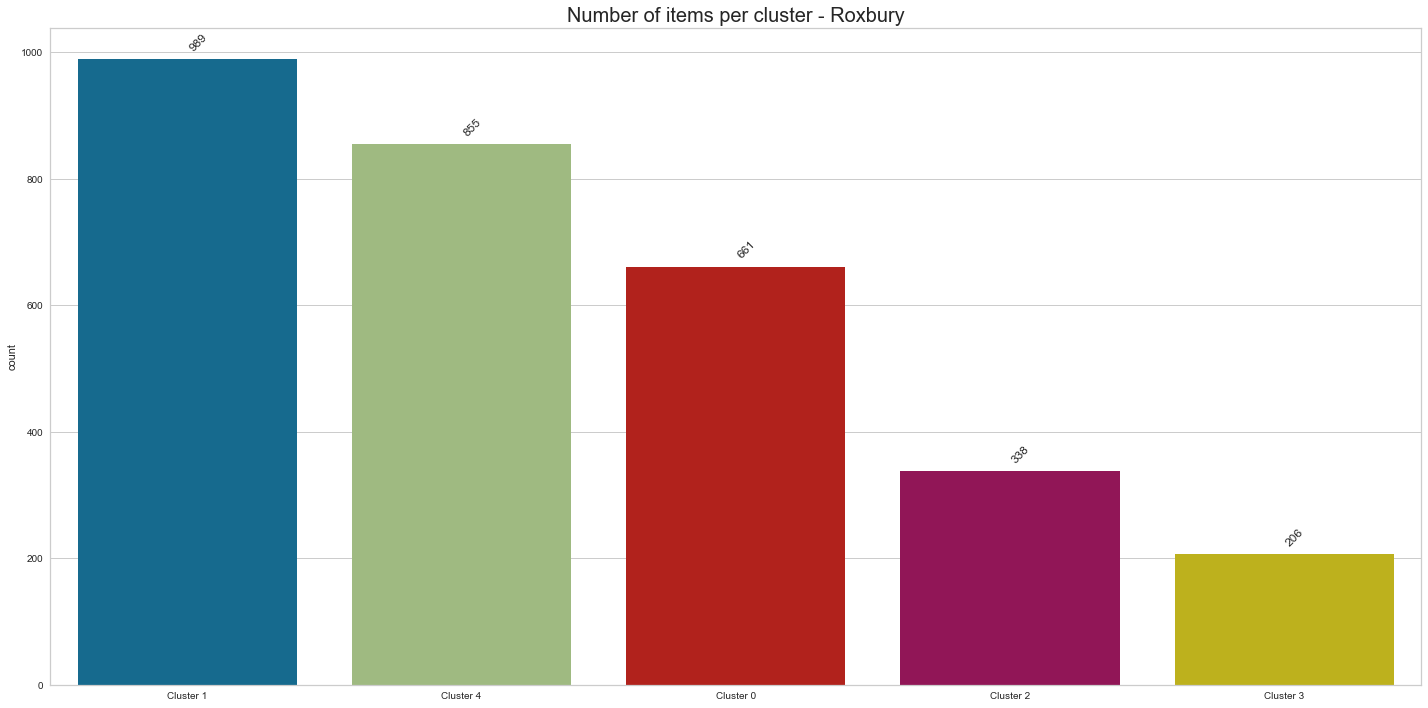

In [60]:
# store selection
store_name = 'Roxbury'
select_store(store_name)

# prepare the data
feature_creation(data)
log_tranform_feat(data)

# apply the model and plot results
model_results = predict_model(model, data=data)
plot_cluster(model_results, store_name)
plot_cluster_distr(model_results,store_name,False)

# cluster renaming
cluster_rename(model_results)

# saving results
filename = ('cluster_model_results_' + store_name + '.csv')
model_results.to_csv(filename)

In [61]:
################################
###        Back_Bay          ###
################################

                   item  frequency  recency
18294  ACCESORIES_1_001        385        9
18295  ACCESORIES_1_002        358        1
18296  ACCESORIES_1_003        178        7
18297  ACCESORIES_1_004       3174        1
18298  ACCESORIES_1_005       1002        1
           frequency  recency
frequency    1.00000 -0.02944
recency     -0.02944  1.00000


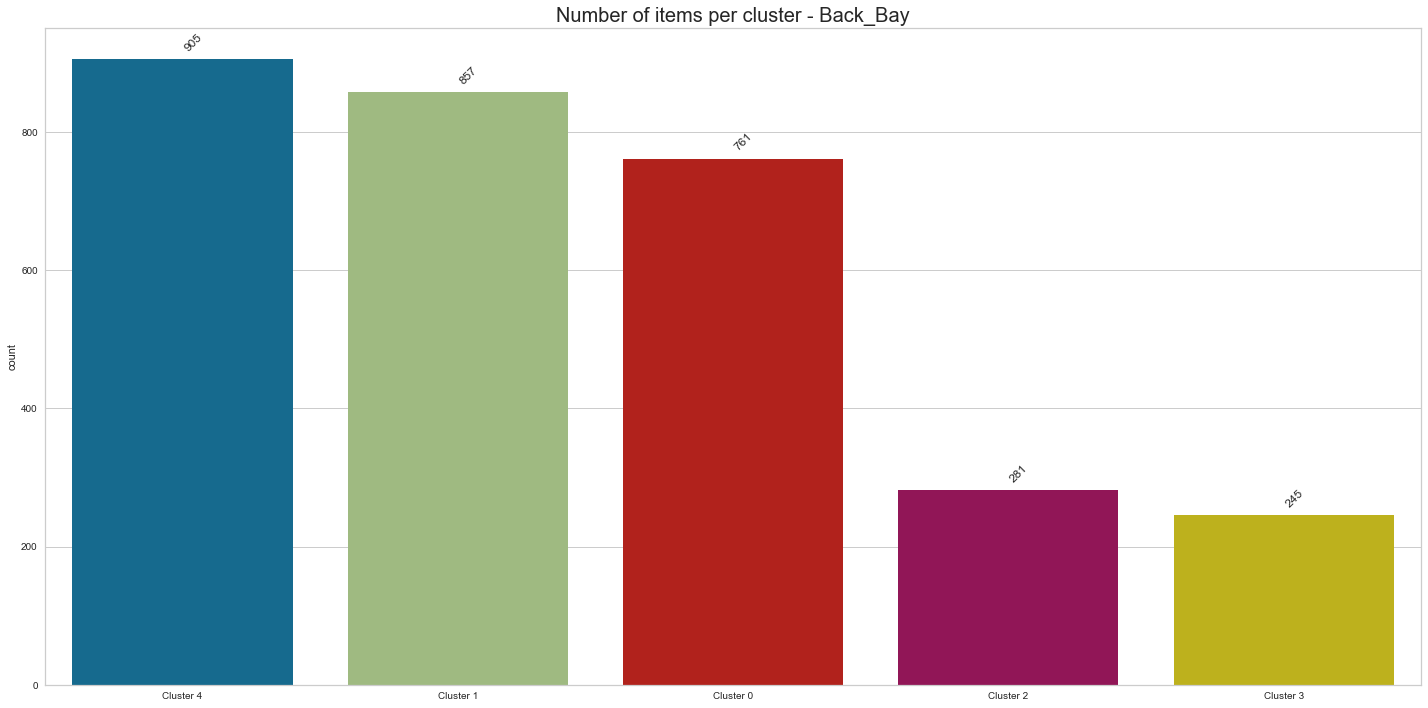

In [62]:
# store selection
store_name = 'Back_Bay'
select_store(store_name)

# prepare the data
feature_creation(data)
log_tranform_feat(data)

# apply the model and plot results
model_results = predict_model(model, data=data)
plot_cluster(model_results, store_name)
plot_cluster_distr(model_results,store_name,False)

# cluster renaming
cluster_rename(model_results)

# saving results
filename = ('cluster_model_results_' + store_name + '.csv')
model_results.to_csv(filename)

In [63]:
##################################
###      Midtown_Village       ###
##################################

In [64]:
# store selection
store_name = 'Midtown_Village'
select_store(store_name)

# prepare the data
feature_creation(data)
log_tranform_feat(data)

# apply the model and plot results
model_results = predict_model(model, data=data)
plot_cluster(model_results, store_name)
plot_cluster_distr(model_results,store_name,False)

# cluster renaming
cluster_rename(model_results)

# saving results
filename = ('cluster_model_results_' + store_name + '.csv')
model_results.to_csv(filename)

In [ ]:
################################
###        Yorktown          ###
################################

In [ ]:
# store selection
store_name = 'Yorktown'
select_store(store_name)

# prepare the data
feature_creation(data)
log_tranform_feat(data)

# apply the model and plot results
model_results = predict_model(model, data=data)
plot_cluster(model_results, store_name)
plot_cluster_distr(model_results,store_name,False)

# cluster renaming
cluster_rename(model_results)

# saving results
filename = ('cluster_model_results_' + store_name + '.csv')
model_results.to_csv(filename)

In [ ]:
################################
###      Queen_Village       ###
################################

In [ ]:
# store selection
store_name = 'Queen_Village'
select_store(store_name)

# prepare the data
feature_creation(data)
log_tranform_feat(data)

# apply the model and plot results
model_results = predict_model(model, data=data)
plot_cluster(model_results, store_name)
plot_cluster_distr(model_results,store_name,False)

# cluster renaming
cluster_rename(model_results)

# saving results
filename = ('cluster_model_results_' + store_name + '.csv')
model_results.to_csv(filename)

In [ ]:
#################################